# Imports and definitions

In [1]:
# Python Modules
import os
from sys import path as syspath
syspath.append("../")

from collections import OrderedDict
from collections.abc import Mapping
import pickle as pkl
import copy

# Data Modules
import numpy as np
import pandas as pd
from scipy.special import logsumexp
from scipy.stats import distributions as dst 

# Util Modules
from util.model_functions import getBrickDict

# Bio Modules
from Bio import SeqIO

# Plotting Modules
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [ ]:
# Definitions
genome = SeqIO.read("../data/Ecoli/NC_000913.gbk", "genbank")

In [4]:
# assign position identities (inside == intragenic, outside == intergenic)
# Coding regions - intragenic
# Non-coding regions - intergenic
fttypes = set([ft.type for ft in genome.features]) # Feature Types
genomeFlags = OrderedDict([])
take = OrderedDict([])


for fttype in fttypes:
    
    # print (fttype)
    take[fttype] = [ft for ft in genome.features if ft.type==fttype]
    nparts = [len(ft.location.parts) for ft in take[fttype]]
    
    # assert all parts within features are on the same strand
    for ft in take[fttype]:
        pts = ft.location.parts
        assert np.all([pt.strand==pts[0].strand for pt in pts])
    locs = [pt for ft in take[fttype] for pt in ft.location.parts]
    x = np.zeros((2, len(genome)))
    print(locs)
    for il, lc in enumerate(locs):
        k = int(lc.strand < 0)
        
        # assert lc.start == lc.nofuzzy_start
        # assert lc.end   == lc.nofuzzy_end
        
        x[k,lc.start:lc.end] = 1
    genomeFlags[fttype] = x


genFilter = OrderedDict([
    ("within", np.vstack([genomeFlags[k] for k in [
                        "misc_feature",
                        # "mobile_element",
                        # "repeat_region",
                        # "rep_origin",
                        # "tRNA",
                        # "STS",
                        # "tmRNA",
                        # "source"
                        # "rRNA",
                        # "ncRNA",
                        "CDS",
                        "gene",
                    ]]).sum(axis=0)>0),
    ("outside", np.vstack([genomeFlags[k] for k in [
                        "misc_feature",
                        "mobile_element",
                        "repeat_region",
                        # "rep_origin",
                        "tRNA",
                        "STS",
                        "tmRNA",
                        # "source"
                        "rRNA",
                        "CDS",
                        "gene",
                        "ncRNA",
                    ]]).sum(axis=0)==0),
    ])


[SimpleLocation(ExactPosition(104532), ExactPosition(104769), strand=1), SimpleLocation(ExactPosition(346454), ExactPosition(347086), strand=1), SimpleLocation(ExactPosition(366293), ExactPosition(366426), strand=1), SimpleLocation(ExactPosition(366294), ExactPosition(366406), strand=1), SimpleLocation(ExactPosition(459107), ExactPosition(460208), strand=1), SimpleLocation(ExactPosition(519225), ExactPosition(519451), strand=1), SimpleLocation(ExactPosition(562094), ExactPosition(562244), strand=1), SimpleLocation(ExactPosition(578393), ExactPosition(578411), strand=1), SimpleLocation(ExactPosition(579658), ExactPosition(579822), strand=1), SimpleLocation(ExactPosition(648178), ExactPosition(648383), strand=1), SimpleLocation(ExactPosition(847359), ExactPosition(847514), strand=1), SimpleLocation(ExactPosition(912483), ExactPosition(912740), strand=1), SimpleLocation(ExactPosition(922430), ExactPosition(922592), strand=1), SimpleLocation(ExactPosition(974890), ExactPosition(975052), st

# Import histograms

## real histograms

freeE_[5]_with_pwi.npy NOT EXIST

In [4]:
FreeEnergy = {}
minimalValue = {}
# with pairwise interactions
freeEs = np.load("Ecoli/freeE_[5]_with_pwi.npy")
minimalValue["with_pwi"] = freeEs.min()
FreeEnergy["with_pwi"] = { fl: freeEs[:,genFilter[fl]].flatten() for fl in genFilter }

# without pairwise interactions
freeEs = np.load("Ecoli/freeE_[5]_without_pwi.npy")
minimalValue["without_pwi"] = freeEs.min()
FreeEnergy["without_pwi"] = { fl: freeEs[:,genFilter[fl]].flatten() for fl in genFilter }
del freeEs

FileNotFoundError: [Errno 2] No such file or directory: 'Ecoli/freeE_[5]_with_pwi.npy'

In [5]:
db = .2
binCenters = {}
realCumulHist = {}
for k in FreeEnergy:
    bbs = np.arange(minimalValue[k]-5, minimalValue[k]+30, db)
    bbs -= db/2
    binCenters[k] = (bbs[:-1]+bbs[1:])/2
    realCumulHist[k] = {fl: np.array([(FreeEnergy[k][fl]<l).sum() for l in bbs[1:]]) for fl in genFilter}

NameError: name 'FreeEnergy' is not defined

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


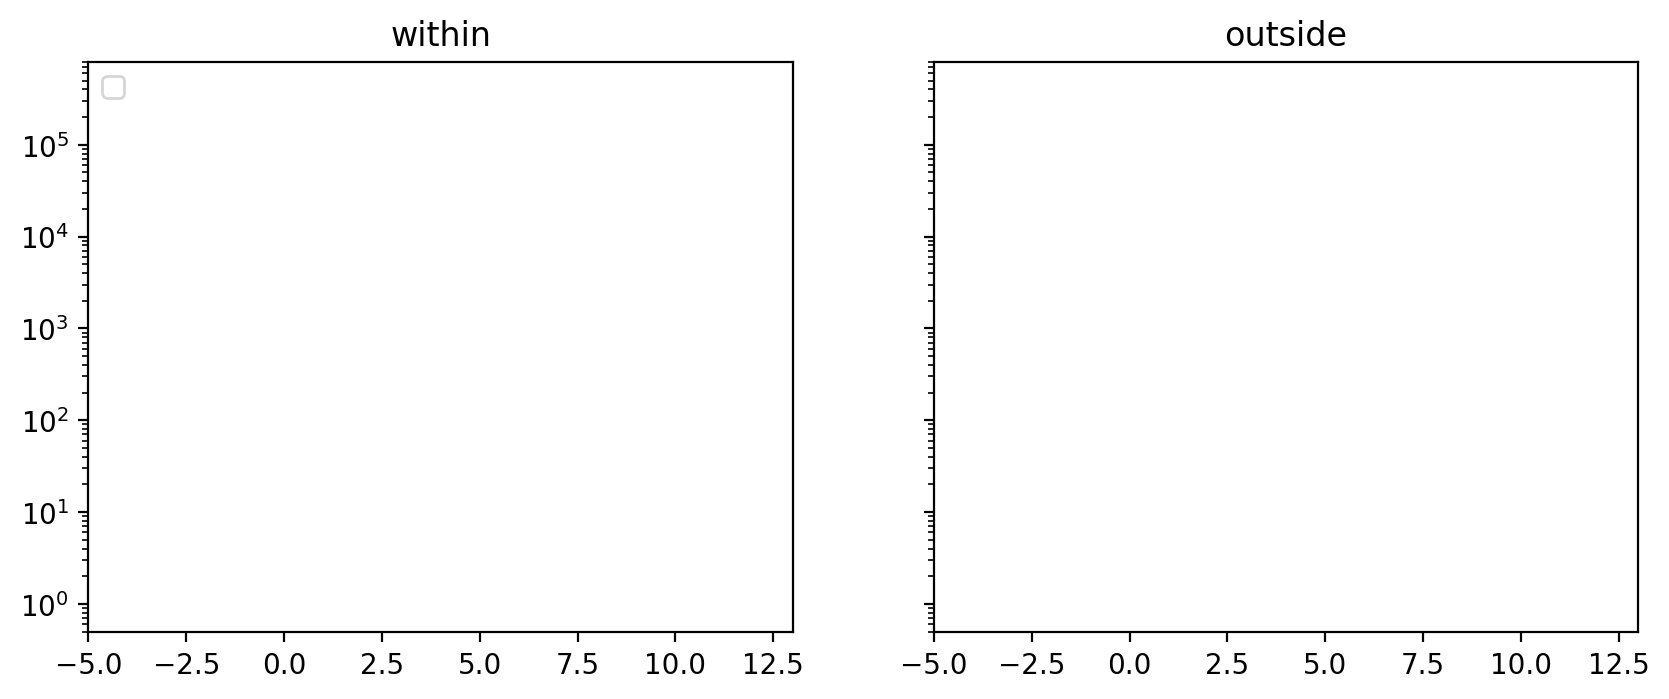

In [6]:
fig, axs = plt.subplots(1,2,figsize=(10,3.7), sharex=True, sharey=True)
for fl, ax in zip(genFilter, axs):
    ax.set_title(fl)
    for k in realCumulHist:
        ax.plot(binCenters[k], realCumulHist[k][fl], label=k)
ax.set_yscale("log")
ax.set_xlim(-5,13)
ax.set_ylim(.5,8e5)
axs[0].legend(loc=2)

## histograms from shuffled matrices

In [7]:
rndCumulHist = {}
for k in ["without_pwi", "with_pwi", "with_pwi_reindexed"]:
    picklename = f"nbdumps/shuffled_matrix_genome_free_energies_{k}.dmp"
    if os.path.isfile(picklename):
        with open(picklename,"rb") as f: rndCumulHist[k] = pkl.load(f)
        print ("imported", picklename)
    else:
        print ("! not found:", picklename)

! not found: nbdumps/shuffled_matrix_genome_free_energies_without_pwi.dmp
! not found: nbdumps/shuffled_matrix_genome_free_energies_with_pwi.dmp
! not found: nbdumps/shuffled_matrix_genome_free_energies_with_pwi_reindexed.dmp


In [9]:
for k in rndCumulHist:
    yrnd  = rndCumulHist[k]
    try:
        x = binCenters[k]-minimalValue[k]
        yreal = realCumulHist[k]
    except:
        x = binCenters[k.replace("_reindexed","")]-minimalValue[k.replace("_reindexed","")]
        yreal = realCumulHist[k.replace("_reindexed","")]
        
    fig,axs = plt.subplots(2,2,figsize=(9,5.5), gridspec_kw={"height_ratios":[3,1.8]}, sharex=True, sharey="row")
    fig.suptitle(k)
    for ax,axl,fl in zip(axs[0], axs[1], sorted(genFilter)):
        y = yrnd[fl]
        ax.set_title("intergenic" if fl=="outside" else "intragenic")
        ax.step(x, yreal[fl], where="mid", color="darkcyan")
        ax.plot(x, y.mean(0), color="k")
#         ax.plot(x, np.percentile(y,  2.5,axis=0), color="darkgrey")
#         ax.plot(x, np.percentile(y, 97.5,axis=0), color="darkgrey")
        ax.fill_between(x,
                       np.percentile(y, 97.5,axis=0),
                       np.percentile(y,  2.5,axis=0), color="darkgrey", alpha = .3)

        pv = dst.norm.cdf(
                yreal[fl],
                loc=y.mean(0),
                scale=y.std(0)+.1,
                )
        axl.plot(x, pv,color="darkcyan")
        axl.axhline(0.05, ls="--", color="k",lw=.7)
        axl.set_xlabel(r"free Energy $\Delta E$")
    ax.set_yscale("log")
    ax.set_xlim(-.2,16)
    ax.set_ylim(.8,2e6)
    axl.set_yscale("log")
    axs[1,0].set_ylabel("p-value")
    axs[0,0].set_ylabel("Cumulative histogram")

    plt.subplots_adjust(hspace=0.01,wspace=0.1)
    plt.savefig(f"Ecoli/shuffled_matrix_{k}.pdf")
    plt.savefig(f"Ecoli/shuffled_matrix_{k}.png", dpi = 300)